In [4]:
install.packages("kknn")
library(kknn)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [58]:
library(tidyverse)
library(DBI)
library(tidymodels)

In [59]:
url <- "https://raw.githubusercontent.com/Ivvvyyan/dsci-group-11/main/StressLevelDataset.csv"
stress <- read_csv(url)
head(stress, n = 3)

Rows: 1100 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (21): anxiety_level, self_esteem, mental_health_history, depression, hea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,⋯,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14,20,0,11,2,1,2,4,2,3,⋯,2,3,2,3,3,2,3,3,2,1
15,8,1,15,5,3,1,4,3,1,⋯,2,1,4,1,5,1,4,5,5,2
12,18,1,14,2,1,2,2,2,2,⋯,2,2,3,3,2,2,3,2,2,1


In [60]:
stress <- stress |>

mutate(stress_level = as_factor(stress_level))|>
mutate(stress_level = fct_recode(stress_level, "Carefree" = "0", "Intermediate" = "1", "Stressful" = "2"))

stress |>
distinct(stress_level)

stress_level
<fct>
Intermediate
Stressful
Carefree


In [61]:
names(stress) <- c("anxiety_level", "self_esteem", "mental_health_history", "depression",
                  "headache", "blood_pressure", "sleep_quality", "breathing_problem",
                  "noise_level", "living_conditions", "safety", "basic_needs", 
                  "academic_performance", "study_load", "teacher_student_relationship", "future_career_concerns",
                  "social_support", "peer_pressure", "extracurricular_activities", "bullying", "stress_level")
head(stress, n=3)

anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,⋯,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
14,20,0,11,2,1,2,4,2,3,⋯,2,3,2,3,3,2,3,3,2,Intermediate
15,8,1,15,5,3,1,4,3,1,⋯,2,1,4,1,5,1,4,5,5,Stressful
12,18,1,14,2,1,2,2,2,2,⋯,2,2,3,3,2,2,3,2,2,Intermediate


In [62]:
#reports the distribution of distinct stress level
num_obs <- nrow(stress)
stress |>
  group_by(stress_level) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

#reports the number of observations in each variable
num_observations <- stress |>
  summarise(across(everything(), ~sum(!is.na(.))))
num_observations

stress_level,count,percentage
<fct>,<int>,<dbl>
Carefree,373,33.90909
Intermediate,358,32.54545
Stressful,369,33.54545


anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,⋯,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,⋯,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100


The above tells us that our data does not have any missing (N/A) values. Therefore, we do not have to worry about removing NA values from our dataset!

In [63]:
stress_selected <- stress |>
select(study_load, peer_pressure, stress_level)

head(stress_selected)

study_load,peer_pressure,stress_level
<dbl>,<dbl>,<fct>
2,3,Intermediate
4,4,Stressful
3,3,Intermediate
4,4,Stressful
3,5,Intermediate
5,4,Stressful


In [64]:
set.seed(12345)
#Splitting the data into training and testing set.
stress_split <- initial_split(stress_selected, prop = 0.75, strata = stress_level)
stress_training <- training(stress_split)
stress_testing <- testing(stress_split)

nrow(stress_training)
nrow(stress_testing)

[1] 823

[1] 277

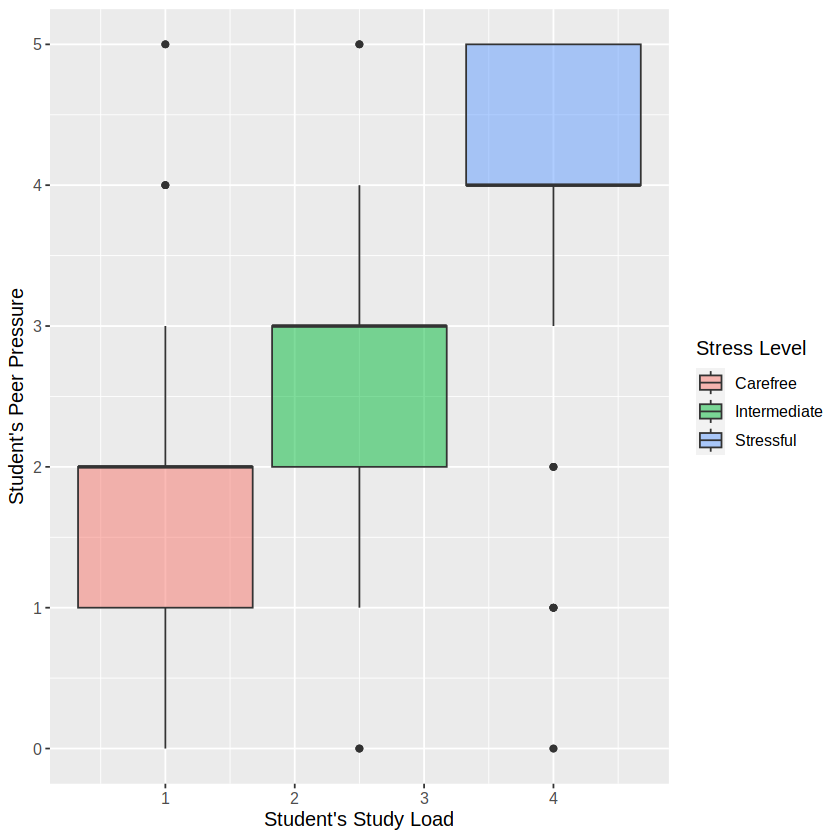

In [65]:
stress_academic <- stress_training |>
    ggplot(aes (x=study_load, y=peer_pressure, fill=stress_level)) +
    geom_boxplot(alpha = 0.5) +
    labs(x="Student's Study Load", y="Student's Peer Pressure", fill="Stress Level") +
    theme(text = element_text(size=12))

stress_academic

In [77]:
stress_vfold <- vfold_cv(stress_training, v=10, strata = stress_level)

In [78]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

In [79]:
stress_recipe <- recipe(stress_level ~ ., data=stress_selected)
stress_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

In [69]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
    add_recipe(stress_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = stress_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5883149,10,0.02709562,Preprocessor1_Model01
6,accuracy,multiclass,0.7472672,10,0.01562922,Preprocessor1_Model02
11,accuracy,multiclass,0.8019895,10,0.01130505,Preprocessor1_Model03
16,accuracy,multiclass,0.8104537,10,0.01152929,Preprocessor1_Model04
21,accuracy,multiclass,0.8104989,10,0.01199626,Preprocessor1_Model05
26,accuracy,multiclass,0.8141280,10,0.01278610,Preprocessor1_Model06
31,accuracy,multiclass,0.8128931,10,0.01194474,Preprocessor1_Model07
36,accuracy,multiclass,0.8177568,10,0.01165402,Preprocessor1_Model08
41,accuracy,multiclass,0.8177568,10,0.01245676,Preprocessor1_Model09


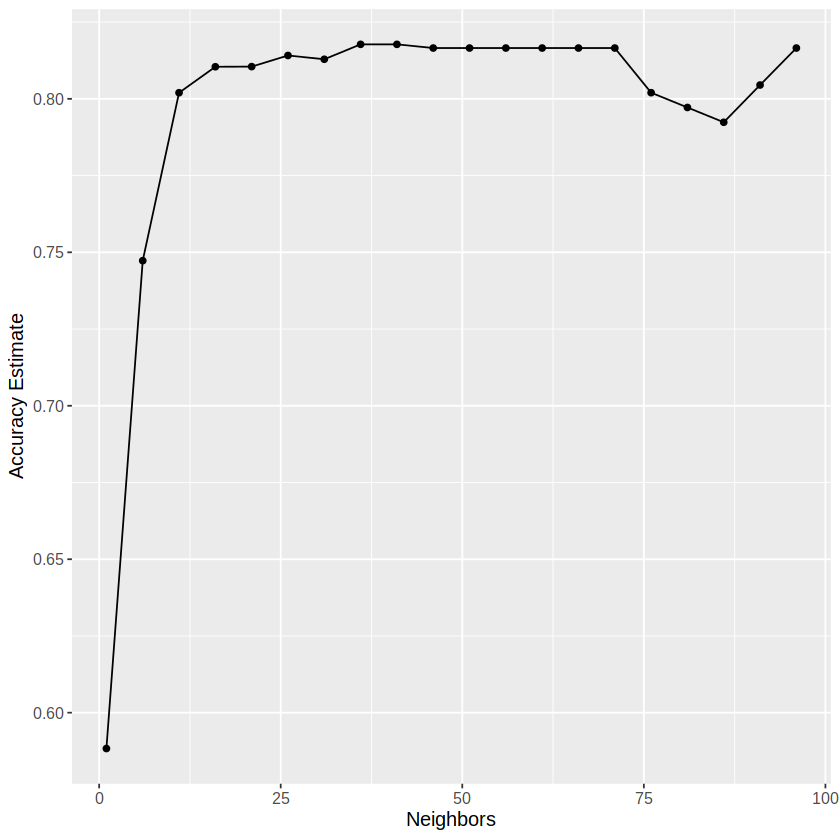

In [70]:
accuracy_vs_k <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x="Neighbors", y="Accuracy Estimate") +
    theme(text=element_text(size=12))

accuracy_vs_k

In [80]:
k_vals_2 <- tibble(neighbors = seq(from = 31, to = 41, by = 1))

knn_results_2 <- workflow() |>
    add_recipe(stress_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = stress_vfold, grid = k_vals_2) |>
    collect_metrics()

accuracies_2 <- knn_results_2 |>
    filter(.metric == "accuracy")

accuracies_2

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,accuracy,multiclass,0.8188867,10,0.007460155,Preprocessor1_Model01
32,accuracy,multiclass,0.8188717,10,0.007504704,Preprocessor1_Model02
33,accuracy,multiclass,0.8164620,10,0.007447034,Preprocessor1_Model03
34,accuracy,multiclass,0.8164918,10,0.007360161,Preprocessor1_Model04
35,accuracy,multiclass,0.8140524,10,0.006605187,Preprocessor1_Model05
36,accuracy,multiclass,0.8140524,10,0.007301079,Preprocessor1_Model06
37,accuracy,multiclass,0.8140524,10,0.007301079,Preprocessor1_Model07
38,accuracy,multiclass,0.8152572,10,0.007275331,Preprocessor1_Model08
39,accuracy,multiclass,0.8152572,10,0.007275331,Preprocessor1_Model09


In [84]:
max_accuracy <- accuracies_2 |>
    slice_max(mean)
max_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,accuracy,multiclass,0.8188867,10,0.007460155,Preprocessor1_Model01


In [85]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 31) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(stress_recipe) |>
    add_model(knn_spec) |>
    fit(data=stress_training)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(31,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.18226
Best kernel: rectangular
Best k: 31

In [86]:
stress_testing_removed <- stress_testing |>
    select(-stress_level)
head(stress_testing_removed, n=3)

study_load,peer_pressure
<dbl>,<dbl>
4,4
3,3
5,4


In [87]:
stress_test_predictions <- predict(knn_fit, stress_testing_removed) |>
    bind_cols(stress_testing)

head(stress_test_predictions, n=5)

.pred_class,study_load,peer_pressure,stress_level
<fct>,<dbl>,<dbl>,<fct>
Stressful,4,4,Stressful
Intermediate,3,3,Intermediate
Stressful,5,4,Stressful
Carefree,2,1,Carefree
Carefree,2,2,Intermediate


In [88]:
stress_accuracy <- stress_test_predictions |>
    metrics(truth=stress_level, estimate= .pred_class) |>
    filter(.metric == "accuracy")

stress_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7689531


In [89]:
stress_confusion <- stress_test_predictions |>
    conf_mat(truth = stress_level, estimate = .pred_class)
stress_confusion

              Truth
Prediction     Carefree Intermediate Stressful
  Carefree           79           33        10
  Intermediate        5           53         2
  Stressful          10            4        81

In [91]:
accuracy <- (79+53+81)/(79+53+81+33+10+6+2+9+4)
accuracy

precision_1 <- 79/(79+5+10)
precision_2 <- 53/(53+33+4)
precision_3 <- 81/(81+10+2)

precision <- (precision_1 + precision_2 + precision_3)/3
precision

recall_1 <- 79/(79+33+10)
recall_2 <- 53/(53+5+2)
recall_3 <- 81/(81+10+4)

recall <- (recall_1 + recall_2 + recall_3)/3
recall

[1] 0.7689531

[1] 0.7667607

[1] 0.794502